In [1]:
import pandas as pd 
import numpy as np

import pysam

import matplotlib.pyplot as plt
from upsetplot import UpSet


KeyboardInterrupt: 

### Transform TRGT format of input regions to tandemTwister/vamos format 

In [13]:
df_TRGT_pathogenic = pd.read_csv("/confidential/tGenVar/Lion/TandemTwist/pathogenic_TR_TRGT.tsv", sep="\t")

df_TRGT_pathogenic.columns = ['chrom', 'start', 'end', 'ID']

#chr16   66490398        66490467        ID=BEAN1;MOTIFS=TGGAA,TAAAA;STRUC=<BEAN1>
# parse the ID field and split it into ID, MOTIFS
df_TRGT_pathogenic['name'] = df_TRGT_pathogenic['ID'].str.split(';').str[0].str.split('=').str[1]
# get the motifs from MOTIFS field
df_TRGT_pathogenic['MOTIFS'] = df_TRGT_pathogenic['ID'].str.split(';').str[1].str.split('=').str[1]
df_TRGT_pathogenic.drop('ID', axis=1, inplace=True)
# order the columns, chrom, start, end, MOTIFS, name
df_TRGT_pathogenic.to_csv("/confidential/tGenVar/Lion/TandemTwist/pathogenic_TRs.bed", sep="\t", index=False, header=False)

### Transform tandemTwister/vamos  format of input regions to TRGT format 

In [3]:

# read the bed file
df = pd.read_csv('/confidential/tGenVar/Lion/TandemTwist/vamos.motif.hg38.v2.1.e0.1.tsv', sep='\t', header=None)
df = df.iloc[:,0:4]
df.columns = ['chrom', 'start', 'end', 'motifs']

def process_row(row):
    chrom = row[0]
    start = row[1]
    end = row[2]
    motifs = row[3].split(',')
    # schuffle the motif list 
    motifs= np.random.permutation(motifs)
    struc = '(' + ')n('.join(motifs) + ')n'
    return f'ID={chrom}_{start}_{end};MOTIFS={",".join(motifs)};STRUC={struc}'

df['new'] = df.apply(process_row, axis=1)
# df["max_motif"] = df['motifs'].apply(lambda x: max(x.split(','), key=len))
# df["max_motif_len"] = df['max_motif'].apply(len)
# print the number of motifs >1# drop the motifs column
df = df.drop('motifs', axis=1)

# save to file withou the header
df.to_csv('/confidential/tGenVar/Lion/TandemTwist/motifs_TRGT_father_1M.bed', header=False, index=False, sep='\t')

/scratch/local/ipykernel_731/3489600155.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chrom = row[0]
/scratch/local/ipykernel_731/3489600155.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  start = row[1]
/scratch/local/ipykernel_731/3489600155.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end = row[2]
/scratch/local/ipykernel_731/3489600155.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprec

In [26]:

def parse_vcf_tandemtwister(vcf):
    df = []
    for record in vcf.fetch():
        ID = record.id
        chrom = ID.split(':')[0]
        start = int(ID.split(':')[1].split('-')[0])
        
        end = int(ID.split(':')[1].split('-')[1])
        motifs = record.info['MOTIFS']
        if (type(motifs) == str):
            # make it as tuple
            motifs = tuple(motifs.split(','))
        motif_ids_H1 = record.info['MOTIF_IDs_H1']
        motif_ids_H2 = record.info['MOTIF_IDs_H2']
        CN_H1 = record.info['CN_H1']
        CN_H2 = record.info['CN_H2']
        CN_ref = record.info['CN_ref']
        if motif_ids_H2 == None and CN_H2 != 0 :
            motif_ids_H2 = motif_ids_H1
         
            


        # get the GT value from the record string 
        GT = str(record).split('\t')[9].split(':')[0]

        df.append([chrom, start, end, motifs, motif_ids_H1, motif_ids_H2, CN_H1, CN_H2, CN_ref, GT])

    # convert to dataframe
    df = pd.DataFrame(df, columns=['chrom', 'start', 'end', 'motifs', 'motif_ids_H1', 'motif_ids_H2', 'CN_H1', 'CN_H2', 'CN_ref', 'GT'])
    return df

def parse_vcf_TRGT(vcf):
    df = []

    for record in vcf.fetch():
        ID = record.info['TRID']
        chrom = ID.split('_')[0]
        start = int(ID.split('_')[1])
        end = int(ID.split('_')[2])
        motifs = record.info['MOTIFS']        
        # make a list of the motifs from the tuple since tuple has no split method
        for sample in record.samples.values():
            mc_value = sample.get('MC')
            if (mc_value[0] == ".")  :
                continue

            # make list of the MC values[0]
            mc_values_hap1 = mc_value[0]
            if len(mc_value) == 1:
                mc_values_hap2 = mc_values_hap1
            else:
                if mc_value[1] == ".":
                    mc_values_hap2 = mc_values_hap1
                else:
                    mc_values_hap2 = mc_value[1]
                    
            mc_values_hap1 = list(map(int, mc_values_hap1.split('_')))
            mc_values_hap2 = list(map(int, mc_values_hap2.split('_')))
         
            # sort the motifs but sort the MC values of mc_values_hap1, and mc_values_hap2 with the same order, but make the sorting based on the motifs
            mc_values_hap1 = [x for _, x in sorted(zip(motifs, mc_values_hap1), key=lambda pair: pair[0])]
            mc_values_hap2 = [x for _, x in sorted(zip(motifs, mc_values_hap2), key=lambda pair: pair[0])]
  
            
            # update the motifs with the sorted motifs
            motifs = sorted(motifs)
            # make the motfs as tuple 
            motifs = tuple(motifs)


            motifs_ids_hap1 = [str(mc_values_hap1.index(i))*i for i in mc_values_hap1]
            motifs_ids_hap2 = [str(mc_values_hap2.index(i))*i for i in mc_values_hap2]
            motifs_ids_hap1 = [char for string in motifs_ids_hap1 for char in string]
            motifs_ids_hap2 = [char for string in motifs_ids_hap2 for char in string]
            # make them tuple again
            motifs_ids_hap1 = tuple(motifs_ids_hap1)
            motifs_ids_hap2 = tuple(motifs_ids_hap2)
            GT = sample['GT']
   

            # make the tuple like 1/2 and so on
            GT = '/'.join([str(i) for i in GT])
            CN_hap1 = len(motifs_ids_hap1)
            CN_hap2 = len(motifs_ids_hap2)
            CN_ref = np.nan
            if GT == '0/0' or GT == '1/1':
                CN_hap2 = CN_hap1
                motifs_ids_hap2 = motifs_ids_hap1
            
            df.append([chrom, start, end, motifs, motifs_ids_hap1, motifs_ids_hap2, CN_hap1, CN_hap2, CN_ref, GT])
    
    # convert to dataframe
    df = pd.DataFrame(df, columns=['chrom', 'start', 'end', 'motifs', 'motif_ids_H1', 'motif_ids_H2', 'CN_H1', 'CN_H2', 'CN_ref', 'GT'])
    
    return df


def parse_vcf_vamos(vcf):
    df = []
    for record in vcf.fetch():
        chrom = record.chrom
        start = record.start +1
        end = record.stop
        motifs = record.info['RU']
        # check if ALTANNO_H1 is in the record
        if 'ALTANNO_H1' in record.info:
            motif_ids_H1 = record.info['ALTANNO_H1']
            
        else:
            motif_ids_H1 = ""
        
        if 'ALTANNO_H2' in record.info:
            motif_ids_H2 = record.info['ALTANNO_H2']
           
        else:
            motif_ids_H2 = ""

        CN_H1 = int(record.info['LEN_H1'])
        if 'LEN_H2' in record.info:
            CN_H2 = int(record.info['LEN_H2'])
        else:
            CN_H2 = CN_H1
            motif_ids_H2 = motif_ids_H1

        CN_ref = np.nan
        GT = record.samples[0]['GT']

        GT = '/'.join([str(i) for i in GT])
        df.append([chrom, start, end, motifs, motif_ids_H1, motif_ids_H2, CN_H1, CN_H2, CN_ref, GT])



    # convert to dataframe
    df = pd.DataFrame(df, columns=['chrom', 'start', 'end', 'motifs', 'motif_ids_H1', 'motif_ids_H2', 'CN_H1', 'CN_H2', 'CN_ref', 'GT'])
    return df

In [10]:
########## Calulate the mendalian consistency

def is_mendelian_consistent_chrY(row, tolerance=0):
    '''
    checks if the child's genotype on chromosome Y is consistent with the father's genotype, allowing for an off-by-one error
    
    Args:
        row: pandas series
        tolerance: int, the allowed deviation (default is 0)
    Returns:

        bool
    '''

    def is_close(a, b):
    
        return abs(a - b) <= tolerance

    # Only males have a Y chromosome
    if row['sex_child'] == 'male':
        child_h1 = row[f'CN_H1_child']
        father_h1 = row[f'CN_H1_father']
        
        return is_close(child_h1, father_h1)
    
    # Females do not have a Y chromosome
    return False

def is_mendelian_consistent_chrX(row, tolerance=0):
    '''
    checks if the child's genotype on chromosome X is consistent with the parents' genotypes, allowing for an off-by-one error
    
    Args:
        row: pandas series
        tolerance: int, the allowed deviation (default is 0)
    Returns:
        bool
    '''

    child_h1 = row[f'CN_H1_child']
    child_h2 = row[f'CN_H2_child']
    father_h1 = row[f'CN_H1_father']
    mother_h1 = row[f'CN_H1_mother']
    mother_h2 = row[f'CN_H2_mother']
    
    def is_close(a, b):
        return abs(a - b) <= tolerance
    
    # If the child is male (XY), he inherits his X chromosome from his mother
    if row['sex_child'] == 'male':
        return is_close(child_h1, mother_h1) or is_close(child_h1, mother_h2)
    
    # If the child is female (XX), she inherits one X chromosome from each parent
    combinations = [
        (is_close(child_h1, father_h1) and (is_close(child_h2, mother_h1) or is_close(child_h2, mother_h2))),
        (is_close(child_h2, father_h1) and (is_close(child_h1, mother_h1) or is_close(child_h1, mother_h2)))
    ]

    return any(combinations)

def is_mendelian_consistent(row, tolerance=0):
    '''
    checks if the child's genotype is consistent with the parents' genotypes, allowing for an off-by-one error
    
    Args:
        row: pandas series
    Returns:
        bool
    '''
    if row['chrom'] == 'chrX':
        return is_mendelian_consistent_chrX(row, tolerance)
    if row['chrom'] == 'chrY':
        return is_mendelian_consistent_chrY(row, tolerance)
    
    child_h1 = row[f'CN_H1_child']
    child_h2 = row[f'CN_H2_child']
    father_h1 = row[f'CN_H1_father']
    father_h2 = row[f'CN_H2_father']
    mother_h1 = row[f'CN_H1_mother']
    mother_h2 = row[f'CN_H2_mother']
    
    def is_close(a, b):
        return abs(a - b) <= tolerance
    
    combinations = [
        (is_close(child_h1, father_h1) and is_close(child_h2, mother_h1)),
        (is_close(child_h1, father_h1) and is_close(child_h2, mother_h2)),
        (is_close(child_h1, father_h2) and is_close(child_h2, mother_h1)),
        (is_close(child_h1, father_h2) and is_close(child_h2, mother_h2)),
        (is_close(child_h2, father_h1) and is_close(child_h1, mother_h1)),
        (is_close(child_h2, father_h1) and is_close(child_h1, mother_h2)),
        (is_close(child_h2, father_h2) and is_close(child_h1, mother_h1)),
        (is_close(child_h2, father_h2) and is_close(child_h1, mother_h2))
    ]

    return any(combinations)

def count_motifs(motif_ids, motifs):
    # Efficiently count motifs using numpy and return a count dictionary
    if pd.isna(motif_ids) or pd.isna(motifs):
        return {}
    unique, counts = np.unique(motif_ids, return_counts=True)
    return dict(zip([motifs[int(i)] for i in unique], counts))


def is_mendelian_consistent_based_on_motif_chrY(row):
    '''
    checks if the child's genotype on chromosome Y is consistent with the father's genotype
    
    Args:
        row: pandas series
    Returns:
        bool
    '''
    if row['sex_child'] == 'male':
        motifs_child = row['motifs_child'] if not pd.isna(row['motifs_child']) else []
        motifs_father = row['motifs_father'] if not pd.isna(row['motifs_father']) else []
        child_h1 = row[f'motif_ids_H1_child']
        child_h1 = {motifs_child[int(i)]: child_h1.count(str(i)) for i in child_h1}
        father_h1 = row[f'motif_ids_H1_father']
        father_h1 = {motifs_father[int(i)]: father_h1.count(str(i)) for i in father_h1}
        


        return child_h1 == father_h1 
    
    return False

def is_mendelian_consistent_based_on_motif_chrX(row):
    '''
    checks if the child's genotype on chromosome X is consistent with the parents' genotypes
    
    Args:
        row: pandas series
    Returns:
        bool
    '''
    motifs_child=  row['motifs_child'] if not pd.isna(row['motifs_child']) else []
    motifs_father = row['motifs_father'] if not pd.isna(row['motifs_father']) else []
    motifs_mother = row['motifs_mother'] if not pd.isna(row['motifs_mother']) else []
    
    child_h1 = row[f'motif_ids_H1_child']
    child_h1 = {motifs_child[int(i)]: child_h1.count(str(i)) for i in child_h1}
    child_h2 = row[f'motif_ids_H2_child']
    child_h2 = {motifs_child[int(i)]: child_h2.count(str(i)) for i in child_h2}
    father_h1 = row[f'motif_ids_H1_father']
    father_h1 = {motifs_father[int(i)]: father_h1.count(str(i)) for i in father_h1}
    mother_h1 = row[f'motif_ids_H1_mother']
    mother_h1 = {motifs_mother[int(i)]: mother_h1.count(str(i)) for i in mother_h1}
    mother_h2 = row[f'motif_ids_H2_mother']
    mother_h2 = {motifs_mother[int(i)]: mother_h2.count(str(i)) for i in mother_h2}

    if row['sex_child'] == 'male':
        return child_h1 in [mother_h1, mother_h2] or child_h2 in [mother_h1, mother_h2]

    combinations = [
        (child_h1 == father_h1 and child_h2 in [mother_h1, mother_h2]),
        (child_h2 == father_h1 and child_h1 in [mother_h1, mother_h2])
    ]
    return any(combinations)



def is_mendelian_consistent_based_on_motif(row):
    '''
    checks if the child's genotype is consistent with the parents' genotypes
    
    Args:
        row: pandas series
    Returns:
        bool
    '''
    if row['chrom'] == 'chrX':
        return is_mendelian_consistent_based_on_motif_chrX(row)
    if row['chrom'] == 'chrY':
        return is_mendelian_consistent_based_on_motif_chrY(row)
    motifs_child=  row['motifs_child'] if not pd.isna(row['motifs_child']) else []
    motifs_father = row['motifs_father'] if not pd.isna(row['motifs_father']) else []
    motifs_mother = row['motifs_mother'] if not pd.isna(row['motifs_mother']) else []
    
    child_h1 = row[f'motif_ids_H1_child']
    child_h1 = {motifs_child[int(i)]: child_h1.count(str(i)) for i in child_h1}
    child_h2 = row[f'motif_ids_H2_child']
    child_h2 = {motifs_child[int(i)]: child_h2.count(str(i)) for i in child_h2}
    father_h1 = row[f'motif_ids_H1_father']
    father_h1 = {motifs_father[int(i)]: father_h1.count(str(i)) for i in father_h1}
    father_h2 = row[f'motif_ids_H2_father']
    father_h2 = {motifs_father[int(i)]: father_h2.count(str(i)) for i in father_h2}
    mother_h1 = row[f'motif_ids_H1_mother']
    mother_h1 = {motifs_mother[int(i)]: mother_h1.count(str(i)) for i in mother_h1}
    mother_h2 = row[f'motif_ids_H2_mother']
    mother_h2 = {motifs_mother[int(i)]: mother_h2.count(str(i)) for i in mother_h2}
    
    
    combinations = [
        (child_h1 == father_h1 and child_h2 == mother_h1),
        (child_h1 == father_h1 and child_h2 == mother_h2),
        (child_h1 == father_h2 and child_h2 == mother_h1),
        (child_h1 == father_h2 and child_h2 == mother_h2),
        (child_h2 == father_h1 and child_h1 == mother_h1),
        (child_h2 == father_h1 and child_h1 == mother_h2),
        (child_h2 == father_h2 and child_h1 == mother_h1),
        (child_h2 == father_h2 and child_h1 == mother_h2)
    ]

    return any(combinations)


def get_mendelian_consistency(child_df, father_df, mother_df, tool, child_sex):
    '''
    This function merges the child, father and mother dataframes and calculates the mendelian consistency for each region
    
    Args:
        child_df: pandas dataframe
        father_df: pandas dataframe
        mother_df: pandas dataframe
        tool: str, the tool used to call the variants
    Returns:
        merged_df: pandas dataframe

    '''
    merged_df_1 = child_df.merge(father_df, on=['chrom', 'start', 'end'], how='left', suffixes=('_child', '_father'))
    merged_df_2 = child_df.merge(mother_df, on=['chrom', 'start', 'end'], how='left', suffixes=('_child', '_mother'))
    merged_df = merged_df_1.merge(merged_df_2, on=['chrom', 'start', 'end', 'motifs_child', 'motif_ids_H1_child', 'motif_ids_H2_child', 'CN_H1_child', 'CN_H2_child', 'CN_ref_child', 'GT_child'], how='left')
    # replace the nan valuse in the cn columns with 0
    merged_df['CN_H1_father'] = merged_df['CN_H1_father'].fillna(0)
    merged_df['CN_H2_father'] = merged_df['CN_H2_father'].fillna(0)
    merged_df['CN_H1_mother'] = merged_df['CN_H1_mother'].fillna(0)
    merged_df['CN_H2_mother'] = merged_df['CN_H2_mother'].fillna(0)
    # replace the nan values in the motif_ids columns with empty string
    merged_df['motif_ids_H1_father'] = merged_df['motif_ids_H1_father'].fillna('')
    merged_df['motif_ids_H2_father'] = merged_df['motif_ids_H2_father'].fillna('')
    merged_df['motif_ids_H1_mother'] = merged_df['motif_ids_H1_mother'].fillna('')
    merged_df['motif_ids_H2_mother'] = merged_df['motif_ids_H2_mother'].fillna('')
    merged_df['motif_ids_H1_child'] = merged_df['motif_ids_H1_child'].fillna('')
    merged_df['motif_ids_H2_child'] = merged_df['motif_ids_H2_child'].fillna('')
    merged_df['CN_ref_father'] = merged_df['CN_ref_father'].fillna(0)
    merged_df['CN_ref_mother'] = merged_df['CN_ref_mother'].fillna(0)
    merged_df['CN_ref_child'] = merged_df['CN_ref_child'].fillna(0)
    merged_df['CN_H1_child'] = merged_df['CN_H1_child'].fillna(0)
    merged_df['CN_H2_child'] = merged_df['CN_H2_child'].fillna(0)

    merged_df['sex_child'] = child_sex

    merged_df['mendelian_consistent_0'] = merged_df.apply(lambda row: is_mendelian_consistent_based_on_motif(row), axis=1)
    merged_df['mendelian_consistent_1'] = merged_df.apply(lambda row: is_mendelian_consistent_based_on_motif(row), axis=1)
    
    #merged_df['mendelian_consistent_motif'] = merged_df.apply(lambda row: is_mendelian_consistent_based_on_motif(row, tolerance=0), axis=1)
    merged_df['tool'] = tool
    merged_df['max_motif_size'] = merged_df['motifs_child'].apply(max_motif_size)
    merged_df['region'] = merged_df['chrom'] + ':' + merged_df['start'].astype(str) + '-' + merged_df['end'].astype(str)

    return merged_df


def max_motif_size(motifs):
    if pd.isna(motifs):
        return 0  
    return max(len(i) for i in motifs)


def print_mendalian_consistency_per_motif_size(df):
    for i in sorted(df['max_motif_size'].unique()):
        print("Mendelian consistency for motif size ", i, " is " , df[df['max_motif_size'] == i]['mendelian_consistent'].sum()/df[df['max_motif_size'] == i].shape[0])
        print(df[df['max_motif_size'] == i]['mendelian_consistent'].value_counts())




def check_agreement(row):
    # Extract haplotype copy numbers for the three tools (tandem_twister, TRGT, vamos)
    twister = abs(row['CN_H1_tandem_twister']+row['CN_H2_tandem_twister'])
    trgt = abs(row['CN_H1_TRGT']+row['CN_H2_TRGT'])
    vamos = abs(row['CN_H1_vamos']+row['CN_H2_vamos'])
    
    # Check agreement between the tools considering haplotype swaps
    if twister == trgt == vamos:
        return 'all_agree'
    elif twister == trgt and twister != vamos:
        return 'vamos_disagree'
    elif twister == vamos and twister != trgt:
        return 'TRGT_disagree'
    elif trgt == vamos and trgt != twister:
        return 'tandem_twister_disagree'
    else:
        return 'all_disagree'
    
        

In [23]:
### sample information
child_sex = "male"

In [ ]:
child_tandemtwister = "/confidential/tGenVar/Lion/TandemTwist/MC/HG002_tandemtwister_CCS.vcf.gz"
father_tandemtwister = "/confidential/tGenVar/Lion/TandemTwist/MC/HG003_tandemtwister_CCS.vcf.gz"
mother_tandemtwister = "/confidential/tGenVar/Lion/TandemTwist/MC/HG004_tandemtwister_CCS.vcf.gz"

# child_tandemtwister = "/confidential/tGenVar/Lion/TandemTwist/MC/HG002_tandemtwister_CLR.vcf.gz"
# father_tandemtwister = "/confidential/tGenVar/Lion/TandemTwist/MC/HG003_tandemtwister_CLR.vcf.gz"
# mother_tandemtwister = "/confidential/tGenVar/Lion/TandemTwist/MC/HG004_tandemtwister_CLR.vcf.gz"

# child_tandemtwister = "/confidential/tGenVar/Lion/TandemTwist/MC/HG002_tandemtwister_ONT.vcf.gz"
# father_tandemtwister = "/confidential/tGenVar/Lion/TandemTwist/MC/HG003_tandemtwister_ONT.vcf.gz"
# mother_tandemtwister = "/confidential/tGenVar/Lion/TandemTwist/MC/HG004_tandemtwister_ONT.vcf.gz"
# child_tandemtwister = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/TandemTwist/CCS/HG002.vcf.gz"
# father_tandemtwister = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/TandemTwist/CCS/HG003.vcf.gz"
# mother_tandemtwister = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/TandemTwist/CCS/HG004.vcf.gz"

child_tandemtwister = pysam.VariantFile(child_tandemtwister)
father_tandemtwister = pysam.VariantFile(father_tandemtwister)
mother_tandemtwister = pysam.VariantFile(mother_tandemtwister)
print("reading the child vcf file")
child_df_tandem_twister= parse_vcf_tandemtwister(child_tandemtwister)
print("reading the father vcf file")
father_df_tandem_twister= parse_vcf_tandemtwister(father_tandemtwister)
print("reading the mother vcf file")
mother_df_tandem_twister= parse_vcf_tandemtwister(mother_tandemtwister)



# in this region chr1:50,482-50,513 both vamos and TRGT reports 10 motifs but tandemtwister reports 9 motifs which is correct! becuase of a SNP in the region
# in this region chr1:15796-15849 both vamos and TRGT reports one copy number more than tandemtwister, look at plot in the notebook

reading the child vcf file
reading the father vcf file
reading the mother vcf file


In [41]:
child_df_tandem_twister
# print the rows that have nan values
#(child_df_tandem_twister.isnull().any(axis=1)) &
child_df_tandem_twister

,chrom,start,end,motifs,motif_ids_H1,motif_ids_H2,CN_H1,CN_H2,CN_ref,GT
0,chr1,10617,10997,"(ATGCTACCGCGTCCAGGGGTGGAGGCGTGGCGCAGGCGCAGAG, ...","(6, 6, 6, 6, 6, 6, 6, 5, 9, 5, 0, 7, 0)","(6, 6, 6, 6, 6, 6, 6, 5, 9, 5, 0, 7, 0)",13,13,12,1/2
1,chr1,11226,11462,(ACTGTATAGTGGTGGCACGCCGCCTGCTGGCAGCTAGGGACATTG...,"(3, 3, 1, 0)","(3, 3, 1, 0)",4,4,4,0/1
2,chr1,15796,15849,"(CATG, CTT, CTC, CTG, CAG)","(1, 2, 3, 2, 1, 3, 1, 1, 1, 2, 4, 1, 2, 1, 0, 3)","(1, 2, 3, 2, 1, 3, 1, 1, 1, 2, 4, 1, 2, 1, 0, 3)",16,16,16,1/2
3,chr1,16713,16744,"(GTG, GGG, GCG)","(0, 1, 0, 0, 0, 1, 2, 0, 1, 0, 0)","(0, 1, 0, 0, 0, 1, 2, 0, 1, 0, 0)",11,11,11,0/1
4,chr1,19306,19443,(TGAGAAGGCAGAGGCGCGACTGGGGTTCATGAGGAAGGGCAGGAG...,"(0, 4)","(0, 4)",2,2,2,0/1
...,...,...,...,...,...,...,...,...,...,...
1240215,chrY,57207138,57207275,(AACCCCTCCACCATCCCACACCCTCCTCCTGCCCTTCCTCATGAA...,None,None,0,0,2,0/0
1240216,chrY,57209843,57209874,"(ACC, CCC, GCC)",None,None,0,0,10,0/0
1240217,chrY,57210763,57210792,"(AAG, CAG, GAG, AAC)",None,None,0,0,10,0/0
1240218,chrY,57215130,57215306,(GAGCAAGAGGGCCCAGCAGTGTCCCCAGCTGCCAGCAGGCGGGCG...,None,None,0,0,3,0/0


In [46]:

child_TRGT = "/confidential/tGenVar/Lion/TandemTwist/MC/HG002_TRGT.vcf.gz"
#child_TRGT = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/TRGT/CCS/HG002.vcf.gz"
father_TRGT = "/confidential/tGenVar/Lion/TandemTwist/MC/HG003_TRGT.vcf.gz"
#father_TRGT = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/TRGT/CCS/HG003.vcf.gz"
mother_TRGT = "/confidential/tGenVar/Lion/TandemTwist/MC/HG004_TRGT.vcf.gz"
#mother_TRGT = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/TRGT/CCS/HG004.vcf.gz"
child_TRGT = pysam.VariantFile(child_TRGT)
father_TRGT = pysam.VariantFile(father_TRGT)
mother_TRGT = pysam.VariantFile(mother_TRGT)
print("reading child vcf")
child_df_tandem_TRGT= parse_vcf_TRGT(child_TRGT)
# print("reading father vcf")
father_df_tandem_TRGT= parse_vcf_TRGT(father_TRGT)
print("reading mother vcf")
mother_df_tandem_TRGT= parse_vcf_TRGT(mother_TRGT)

[W::hts_idx_load3] The index file is older than the data file: /confidential/tGenVar/Lion/TandemTwist/MC/HG002_TRGT.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: /confidential/tGenVar/Lion/TandemTwist/MC/HG003_TRGT.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: /confidential/tGenVar/Lion/TandemTwist/MC/HG004_TRGT.vcf.gz.tbi


reading child vcf
reading mother vcf


In [5]:
import subprocess

# child_vamos = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/vamos/CCS/HG002.vcf"
# father_vamos = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/vamos/CCS/HG003.vcf"
# mother_vamos = "/confidential/tGenVar/vntr/output_maryam/tools/run_all_tools/output/Ashkenazi/vamos/CCS/HG004.vcf"
# child_vamos = "/confidential/tGenVar/Lion/TandemTwist/MC/HG002_vamos_no_HP.vcf"
# father_vamos = "/confidential/tGenVar/Lion/TandemTwist/MC/HG003_vamos_no_HP.vcf"
# mother_vamos = "/confidential/tGenVar/Lion/TandemTwist/MC/HG004_vamos_no_HP.vcf"

child_vamos = "/confidential/tGenVar/Lion/TandemTwist/MC/HG002_vamos_ONT.vcf"
father_vamos = "/confidential/tGenVar/Lion/TandemTwist/MC/HG003_vamos_ONT.vcf"
mother_vamos = "/confidential/tGenVar/Lion/TandemTwist/MC/HG004_vamos_ONT.vcf"


# Funktion zum Komprimieren und Indexieren einer Datei
def compress_and_index(file_path):
    # Komprimieren mit bgzip
    subprocess.run(['bgzip', '-c', file_path], stdout=open(file_path + '.gz', 'wb'))
    # Indexieren mit tabix
    subprocess.run(['tabix', '-p', 'vcf', file_path + '.gz'])

# open the files and save them as gzip

compress_and_index(child_vamos)
compress_and_index(father_vamos)
compress_and_index(mother_vamos)

print("zipp is done ")
child_vamos = pysam.VariantFile(child_vamos+'.gz')
father_vamos = pysam.VariantFile(father_vamos+'.gz')
mother_vamos = pysam.VariantFile(mother_vamos+'.gz')
print("reading child vcf")
child_df_vamos = parse_vcf_vamos(child_vamos)
father_df_vamos = parse_vcf_vamos(father_vamos)
mother_df_vamos = parse_vcf_vamos(mother_vamos)

zipp is done 


[E::bcf_hdr_parse_line] Could not parse the header line: "##INFO=<ID=ALTANNO_H1,Number=1,Type=String,Description=\"\"Motif representation for the h1 alternate allele>"
[E::bcf_hdr_parse_line] Could not parse the header line: "##INFO=<ID=ALTANNO_H2,Number=1,Type=String,Description=\"\"Motif representation for the h2 alternate allele>"
[E::bcf_hdr_parse_line] Could not parse the header line: "##INFO=<ID=LEN_H1,Number=1,Type=Integer,Description=\"\"Length of the motif annotation for the h1 alternate allele>"
[E::bcf_hdr_parse_line] Could not parse the header line: "##INFO=<ID=LEN_H2,Number=1,Type=Integer,Description=\"\"Length of the motif annotation for the h2 alternate allele>"
[E::bcf_hdr_parse_line] Could not parse the header line: "##INFO=<ID=ALTANNO_H1,Number=1,Type=String,Description=\"\"Motif representation for the h1 alternate allele>"
[E::bcf_hdr_parse_line] Could not parse the header line: "##INFO=<ID=ALTANNO_H2,Number=1,Type=String,Description=\"\"Motif representation for the 

reading child vcf


[W::vcf_parse_info] INFO 'ALTANNO_H1' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'LEN_H1' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'ALTANNO_H2' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'LEN_H2' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'ALTANNO_H1' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'LEN_H1' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'ALTANNO_H2' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'LEN_H2' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'ALTANNO_H1' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'LEN_H1' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'ALTANNO_H2' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'LEN_H2' is not 

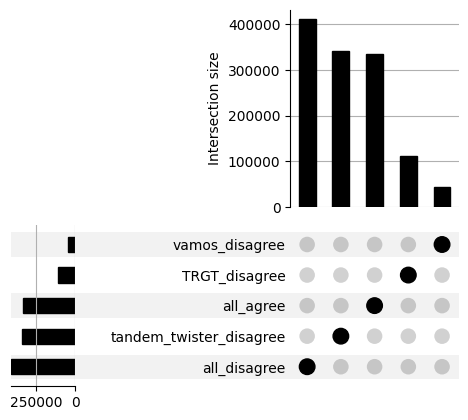

In [12]:
# read the motif file
motif_file = "/confidential/tGenVar/Lion/TandemTwist/vamos.motif.hg38.v2.1.e0.1.tsv"
# read the first 4 columns of the motif file
motif_df = pd.read_csv(motif_file, sep='\t', usecols=[0, 1, 2, 3], header=None)
# create a header 
motif_df.columns = ['chrom', 'start', 'end', 'motifs']
# merge the child results of the three tools with the motif file
df = motif_df.merge(child_df_tandem_twister, on=['chrom', 'start', 'end'], how='left', suffixes=('_motif', '_tandem_twister'))
df = df.merge(child_df_tandem_TRGT, on=['chrom', 'start', 'end',], how='left', suffixes=('_tandem_twister', '_TRGT'))
df = df.merge(child_df_vamos, on=['chrom', 'start', 'end'], how='left', suffixes=('_TRGT', '_vamos'))

copynumbers = df[['chrom','start','end','motifs_motif','CN_H1_tandem_twister','CN_H2_tandem_twister','CN_H1_TRGT','CN_H2_TRGT','CN_H1','CN_H2' ]]
copynumbers.columns = ['chrom','start','end','motifs','CN_H1_tandem_twister','CN_H2_tandem_twister','CN_H1_TRGT','CN_H2_TRGT','CN_H1_vamos','CN_H2_vamos']
# make the CN columns as integers
# fill the nan values with 0
copynumbers = copynumbers.fillna(0)

copynumbers['CN_H1_tandem_twister'] = copynumbers['CN_H1_tandem_twister'].astype(int)
copynumbers['CN_H2_tandem_twister'] = copynumbers['CN_H2_tandem_twister'].astype(int)
copynumbers['CN_H1_TRGT'] = copynumbers['CN_H1_TRGT'].astype(int)
copynumbers['CN_H2_TRGT'] = copynumbers['CN_H2_TRGT'].astype(int)
copynumbers['CN_H1_vamos'] = copynumbers['CN_H1_vamos'].astype(int)
copynumbers['CN_H2_vamos'] = copynumbers['CN_H2_vamos'].astype(int)
copynumbers['agreement'] = copynumbers.apply(check_agreement, axis=1)



copynumbers['tandem_twister_disagree'] = copynumbers['agreement'] == 'tandem_twister_disagree'
copynumbers['TRGT_disagree'] = copynumbers['agreement'] == 'TRGT_disagree'
copynumbers['vamos_disagree'] = copynumbers['agreement'] == 'vamos_disagree'
copynumbers['all_disagree'] = copynumbers['agreement'] == 'all_disagree'
copynumbers['all_agree'] = copynumbers['agreement'] == 'all_agree'

# Convert to integer binary representation (0 or 1)
binary_columns = copynumbers[['tandem_twister_disagree', 'TRGT_disagree', 'vamos_disagree', 'all_disagree', 'all_agree']].astype(int)

# Group the data by combinations of binary columns and count occurrences
counts = binary_columns.groupby(
    ['tandem_twister_disagree', 'TRGT_disagree', 'vamos_disagree', 'all_disagree', 'all_agree']
).size()

# Reset the index to convert it to a MultiIndex, which is required for UpSet
counts = counts.reset_index()

# Convert columns into a MultiIndex for the UpSet plot
counts = counts.set_index(['tandem_twister_disagree', 'TRGT_disagree', 'vamos_disagree', 'all_disagree', 'all_agree'])[0]

# Create the UpSet plot
upset = UpSet(counts, orientation='horizontal')
upset.plot()

# Show the plot
plt.show()

In [ ]:
pd.set_option('display.max_rows', 200)
copynumbers.head(200)
# make an upset plot from the column all_agree
copynumbers[copynumbers['tandem_twister_disagree'] == 1].head(200)
# check this region for tandemTwister	
# chr1:104161-104196	
# chr1	109565	109614 # in this region tandemtwister is right and vamos, TRGT are wrong
# check these : chr1	178283	178336,  chr1	933011	933048
# chr1	414630	414675	the region is clearly hetrotzygous but vamos and TRGT reports it as homozygous
# chr1	640899	640928 homopolymer region, TRGT and Vamos are wrong in this region
# chr1	1845825	1845872  # this is an interesting region, tandemtwister is right and vamos, TRGT are wrong, it is a hetrotzygous region
# interesting region : chr1:432,156-432,331
# look at this region in TandemTwister chr1	9311161	9311178 we say it's hetrotzygous but TRGT and Vamos say it's homozygous which is true 
# chr1	1604266	1604292 this region is genotyped correctly by tandemtwister but not by others
# very differen results :chr1	7551284	7551372	


In [14]:
def get_number_of_motifs_found_in_region(row):
    # get the unique motifs in the region
    if pd.isna(row['motif_ids_H1']) or pd.isna(row['motif_ids_H2']):
        return 0
    
    return max(len(set(row['motif_ids_H1'])), len(set(row['motif_ids_H2'])))

In [15]:
child_df_tandem_twister['number_of_motifs_found'] = child_df_tandem_twister.apply(get_number_of_motifs_found_in_region, axis=1)
child_df_tandem_TRGT['number_of_motifs_found'] = child_df_tandem_TRGT.apply(get_number_of_motifs_found_in_region, axis=1)
child_df_vamos['number_of_motifs_found'] = child_df_vamos.apply(get_number_of_motifs_found_in_region, axis=1)

child_df_tandem_twister['index'] = child_df_tandem_twister.index
child_df_tandem_TRGT['index'] = child_df_tandem_TRGT.index
child_df_vamos['index'] = child_df_vamos.index

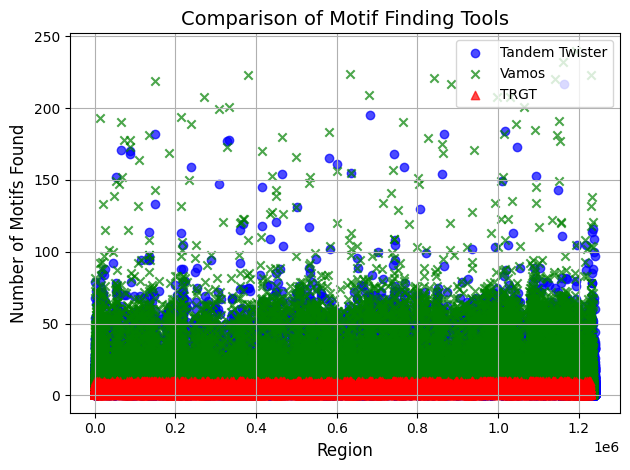

In [16]:
import matplotlib.pyplot as plt

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the data with different markers and transparency for better distinction
ax.scatter(child_df_tandem_twister['index'], child_df_tandem_twister['number_of_motifs_found'], 
           label='Tandem Twister', marker='o', color='blue', alpha=0.7)
ax.scatter(child_df_vamos['index'], child_df_vamos['number_of_motifs_found'], 
           label='Vamos', marker='x', color='green', alpha=0.7)
ax.scatter(child_df_tandem_TRGT['index'], child_df_tandem_TRGT['number_of_motifs_found'], 
           label='TRGT', marker='^', color='red', alpha=0.7)

# Set labels and title
ax.set_xlabel('Region', fontsize=12)
ax.set_ylabel('Number of Motifs Found', fontsize=12)
ax.set_title('Comparison of Motif Finding Tools', fontsize=14)

# Add gridlines for easier reading of points
ax.grid(True)

# Add a legend in the upper right corner
ax.legend(loc='upper right', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


In [43]:


tandemtwister = get_mendelian_consistency(child_df_tandem_twister, father_df_tandem_twister, mother_df_tandem_twister, 'tandem_twister', child_sex)
#print_mendalian_consistency_per_motif_size(tandemtwister)
print ("number of regions in tandemtwister ", tandemtwister.shape[0])   
print("percentage of mendelian consistent regions for tandemtwister ", tandemtwister['mendelian_consistent_0'].sum()/tandemtwister.shape[0])
print("percentage of mendelian consistent off by one regions for tandemtwister ", tandemtwister['mendelian_consistent_1'].sum()/tandemtwister.shape[0])
print("percentage of mendelian consistent regions for tandemtwister with motif size > 1 ", tandemtwister[tandemtwister['max_motif_size'] > 1]['mendelian_consistent_0'].sum()/tandemtwister[tandemtwister['max_motif_size'] > 1].shape[0])
print("percentage of mendelian consistent off by one regions for tandemtwister with motif size > 1 ", tandemtwister[tandemtwister['max_motif_size'] > 1]['mendelian_consistent_1'].sum()/tandemtwister[tandemtwister['max_motif_size'] > 1].shape[0])
print("recall for tandemtwister ", tandemtwister.shape[0]/1243954)
# save the regions where the mendelian consistency is not met
#
# number of regions in tandemtwister  1243404
# percentage of mendelian consistent regions for tandemtwister  0.9304288871517222
# percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.9691139288364202
# recall for tandemtwister  0.9995578614643307


#### results after adding the occurences of the motifs to the clustering and the occurences of the nucleotides
#number of regions in tandemtwister  1243404
# percentage of mendelian consistent regions for tandemtwister  0.9069176229125852
# percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.9484312159435153
# recall for tandemtwister  0.9995578614643307


###### results after adding only the occurences of the motifs to the clustering 
# number of regions in tandemtwister  1243404
# percentage of mendelian consistent regions for tandemtwister  0.9237279275279796
# percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.9607385737983053


# number of regions in tandemtwister  1242676
# percentage of mendelian consistent regions for tandemtwister  0.9049720120127853
# percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.9376645167758637
# recall for tandemtwister  0.9989726308207538


####### result of tandemTwister based on the mendelian consistency of each motif occurences
# number of regions in tandemtwister  1242676
# percentage of mendelian consistent regions for tandemtwister  0.9115602136035459
# percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.9430794419174794
# recall for tandemtwister  0.9989726308207538
####### result of tandemTwister based on the mendelian consistency of copy number in the region 
# number of regions in tandemtwister  1242676
# percentage of mendelian consistent regions for tandemtwister  0.9439258503423258
# percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.9743753446398862
# recall for tandemtwister  0.9989726308207538


#### after fixing the bug in the code
####### result of tandemTwister based on the mendelian consistency of each motif occurences

# number of regions in tandemtwister  1240221
# percentage of mendelian consistent regions for tandemtwister  0.9164527934940627
# percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.9486537997701552
# recall for tandemtwister  0.9969990851751753


# number of regions in tandemtwister  1240221
# percentage of mendelian consistent regions for tandemtwister  0.9490510159076487
# percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.9802210483005197
# recall for tandemtwister  0.9969990851751753



##### CLR results
# MC 
# number of regions in tandemtwister  1240221
# number of regions in tandemtwister  1240220
# percentage of mendelian consistent regions for tandemtwister  0.5178540904033155
# percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.5857444993255987
# recall for tandemtwister  0.9969982812869286

#MC off by one
# number of regions in tandemtwister  1240220
# percentage of mendelian consistent regions for tandemtwister  0.8182814339391399
# percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.8660447923543889
# recall for tandemtwister  0.9969982812869286


##ONT 
# number of regions in tandemtwister  1240220
# percentage of mendelian consistent regions for tandemtwister  0.6353058328361098
# percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.6881494541416564
# recall for tandemtwister  0.9969982812869286

## ONT off by one
# number of regions in tandemtwister  1240220
# percentage of mendelian consistent regions for tandemtwister  0.8663083968973246
# percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.8995104205880629
# recall for tandemtwister  0.9969982812869286


##### CCS MC based on Motif :
# number of regions in tandemtwister  1240220
# percentage of mendelian consistent regions for tandemtwister  0.9290375901049813
# percentage of mendelian consistent off by one regions for tandemtwister  0.9290375901049813
# percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.9572166615905278
# percentage of mendelian consistent off by one regions for tandemtwister with motif size > 1  0.9572166615905278
# recall for tandemtwister  0.9969982812869286

number of regions in tandemtwister  1240220
percentage of mendelian consistent regions for tandemtwister  0.9290375901049813
percentage of mendelian consistent off by one regions for tandemtwister  0.9290375901049813
percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.9572166615905278
percentage of mendelian consistent off by one regions for tandemtwister with motif size > 1  0.9572166615905278
recall for tandemtwister  0.9969982812869286


In [48]:
print ("number of regions in tandemtwister ", tandemtwister.shape[0])   
print("percentage of mendelian consistent regions for tandemtwister ", tandemtwister['mendelian_consistent_0'].sum()/tandemtwister.shape[0])
print("percentage of mendelian consistent regions for tandemtwister with motif size > 1 ", tandemtwister[tandemtwister['max_motif_size'] > 1]['mendelian_consistent_0'].sum()/tandemtwister[tandemtwister['max_motif_size'] > 1].shape[0])
print("recall for tandemtwister ", tandemtwister.shape[0]/1243954)

number of regions in tandemtwister  1240220
percentage of mendelian consistent regions for tandemtwister  0.9290375901049813
percentage of mendelian consistent regions for tandemtwister with motif size > 1  0.9572166615905278
recall for tandemtwister  0.9969982812869286


In [16]:
tandemtwister[tandemtwister["mendelian_consistent_0"] == True][["CN_H1_child", "CN_H2_child", "CN_H1_father", "CN_H2_father", "CN_H1_mother", "CN_H2_mother", "mendelian_consistent_0", "chrom", "start", "end", "motifs_child", "motif_ids_H1_child", "motif_ids_H2_child", "motif_ids_H1_father", "motif_ids_H2_father", "motif_ids_H1_mother", "motif_ids_H2_mother"]]
# count the number of regions where all CNs are 0
tandemtwister[(tandemtwister["CN_H1_child"] == 0) & (tandemtwister["CN_H2_child"] == 0) & (tandemtwister["CN_H1_father"] == 0) & (tandemtwister["CN_H2_father"] == 0) & (tandemtwister["CN_H1_mother"] == 0) & (tandemtwister["CN_H2_mother"] == 0)]


,chrom,start,end,motifs_child,motif_ids_H1_child,motif_ids_H2_child,CN_H1_child,CN_H2_child,CN_ref_child,GT_child,...,CN_H1_mother,CN_H2_mother,CN_ref_mother,GT_mother,sex_child,mendelian_consistent_0,mendelian_consistent_1,tool,max_motif_size,region
684,chr1,1427636,1427719,"(CGCCTAGCC, CTGCCTGC, TCGCTGC, CTCCGCC, CGCTGC...",,,0,0,12,0/0,...,0,0,12,0/0,male,True,True,tandem_twister,9,chr1:1427636-1427719
685,chr1,1427958,1428214,"(GAGGGG, GAGGG, GAAGA, GAGAG, CAGGG, AAAGA, GA...",,,0,0,52,0/0,...,0,0,52,0/0,male,True,True,tandem_twister,6,chr1:1427958-1428214
1250,chr1,2325095,2325326,"(CTTCC, CTTTC, CTTC, CTCC, CTTT)",,,0,0,52,0/0,...,0,0,52,0/0,male,True,True,tandem_twister,5,chr1:2325095-2325326
15262,chr1,29552273,29553942,"(ACCACC, ATCACC, ACCATC, GTCACC, ACTACC, ACCGT...",,,0,0,18,0/0,...,0,0,18,0/0,male,True,True,tandem_twister,6,chr1:29552273-29553942
29872,chr1,62686158,62686192,"(T,)",,,0,0,35,0/0,...,0,0,35,0/0,male,True,True,tandem_twister,1,chr1:62686158-62686192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240215,chrY,57207138,57207275,(AACCCCTCCACCATCCCACACCCTCCTCCTGCCCTTCCTCATGAA...,,,0,0,2,0/0,...,0,0,2,0/0,male,True,True,tandem_twister,70,chrY:57207138-57207275
1240216,chrY,57209843,57209874,"(ACC, CCC, GCC)",,,0,0,10,0/0,...,0,0,10,0/0,male,True,True,tandem_twister,3,chrY:57209843-57209874
1240217,chrY,57210763,57210792,"(AAG, CAG, GAG, AAC)",,,0,0,10,0/0,...,0,0,10,0/0,male,True,True,tandem_twister,3,chrY:57210763-57210792
1240218,chrY,57215130,57215306,(GAGCAAGAGGGCCCAGCAGTGTCCCCAGCTGCCAGCAGGCGGGCG...,,,0,0,3,0/0,...,0,0,3,0/0,male,True,True,tandem_twister,63,chrY:57215130-57215306


In [18]:
tandemtwister[tandemtwister["max_motif_size"] ==1]

,chrom,start,end,motifs_child,motif_ids_H1_child,motif_ids_H2_child,CN_H1_child,CN_H2_child,CN_ref_child,GT_child,...,motif_ids_H2_mother,CN_H1_mother,CN_H2_mother,CN_ref_mother,GT_mother,sex_child,mendelian_consistent,tool,max_motif_size,region


In [47]:
TRGT = get_mendelian_consistency(child_df_tandem_TRGT, father_df_tandem_TRGT, mother_df_tandem_TRGT, 'TRGT',child_sex)
#print_mendalian_consistency_per_motif_size(TRGT)
print ("number of  regions in TRGT ", TRGT.shape[0])
print("Number of mendelian consistent regions for TRGT ", TRGT['mendelian_consistent_0'].sum()/TRGT.shape[0])
print("Number of mendelian consistent off by one regions for TRGT ", TRGT['mendelian_consistent_1'].sum()/TRGT.shape[0])
print("Number of mendelian consistent regions for TRGT with motif size > 1 ", TRGT[TRGT['max_motif_size'] > 1]['mendelian_consistent_0'].sum()/TRGT[TRGT['max_motif_size'] > 1].shape[0])

# print("recall for TRGT ", TRGT.shape[0]/1243954)
# number of  regions in TRGT  1228157
# Number of mendelian consistent regions for TRGT  0.9493102266241206
# Number of mendelian consistent regions for TRGT with motif size > 1  0.9720300427257765
# recall for TRGT  0.9873009773673304
###### results of TRGT based on the mendelian consistency of each motif occurences
# number of  regions in TRGT  1237813
# Number of mendelian consistent regions for TRGT  0.9282573377400302
# Number of mendelian consistent regions for TRGT with motif size > 1  0.9448034752455079
###### results of TRGT based on the mendelian consistency of copy number in the region
# number of  regions in TRGT  1237813
# Number of mendelian consistent regions for TRGT  0.9535301374278667
# Number of mendelian consistent regions for TRGT with motif size > 1  0.9744368595832169


number of  regions in TRGT  1237813
Number of mendelian consistent regions for TRGT  0.9282573377400302
Number of mendelian consistent off by one regions for TRGT  0.9282573377400302
Number of mendelian consistent regions for TRGT with motif size > 1  0.9448034752455079


In [8]:
vamos = get_mendelian_consistency(child_df_vamos, father_df_vamos, mother_df_vamos, 'vamos',child_sex)
#print_mendalian_consistency_per_motif_size(vamos)
print ("number of regions in vamos ", vamos.shape[0])
print("Number of mendelian consistent regions for vamos ", vamos['mendelian_consistent_0'].sum()/vamos.shape[0])
print("Number of mendelian consistent off by one regions for vamos ", vamos['mendelian_consistent_1'].sum()/vamos.shape[0])
print("Number of mendelian consistent regions for vamos with motif size > 1 ", vamos[vamos['max_motif_size'] > 1]['mendelian_consistent_0'].sum()/vamos[vamos['max_motif_size'] > 1].shape[0])
print("Number of mendelian consistent regions off by one for vamos with motif size > 1 ", vamos[vamos['max_motif_size'] > 1]['mendelian_consistent_1'].sum()/vamos[vamos['max_motif_size'] > 1].shape[0])
print("recall for vamos ", vamos.shape[0]/1243954)

#### CLR 
# number of regions in vamos  1239659
# Number of mendelian consistent regions for vamos  0.43918287206401113
# Number of mendelian consistent off by one regions for vamos  0.7118239774002367
# Number of mendelian consistent regions for vamos with motif size > 1  0.5369489043460071
# Number of mendelian consistent regions off by one for vamos with motif size > 1  0.8087400432690204
# recall for vamos  0.9965472999805459



number of regions in vamos  1238370
Number of mendelian consistent regions for vamos  0.49914080605957833
Number of mendelian consistent off by one regions for vamos  0.7762518471862206
Number of mendelian consistent regions for vamos with motif size > 1  0.6004026202336948
Number of mendelian consistent regions off by one for vamos with motif size > 1  0.8646258844676329
recall for vamos  0.9955110880305863


In [12]:
TandemTwister_MC =  tandemtwister['mendelian_consistent_0'].sum()/tandemtwister.shape[0]
#TandemTwister_MC_motif =  tandemtwister['mendelian_consistent_0_motif'].sum()/tandemtwister.shape[0]
Vamos_MC = vamos['mendelian_consistent_0'].sum()/vamos.shape[0]
#Vamos_MC_motif = vamos['mendelian_consistent_0_motif'].sum()/vamos.shape[0]

#TRGT_MC = TRGT['mendelian_consistent_0'].sum()/TRGT.shape[0]
#TRGT_MC_motif = TRGT['mendelian_consistent_0_motif'].sum()/TRGT.shape[0]

In [13]:
TandemTwister_MC_off_by_one = tandemtwister['mendelian_consistent_1'].sum()/tandemtwister.shape[0]
#TandemTwister_MC_off_by_one_motif = tandemtwister['mendelian_consistent_1_motif'].sum()/tandemtwister.shape[0]
Vamos_MC_off_by_one = vamos['mendelian_consistent_1'].sum()/vamos.shape[0]
#Vamos_MC_off_by_one_motif = vamos['mendelian_consistent_1_motif'].sum()/vamos.shape[0]

#TRGT_MC_off_by_one = TRGT['mendelian_consistent_1'].sum()/TRGT.shape[0]
##TRGT_MC_off_by_one_motif = TRGT['mendelian_consistent_1_motif'].sum()/TRGT.shape[0]

In [14]:
recall_TandemTwister_MC = tandemtwister.shape[0]/1243954
recall_Vamos_MC = vamos.shape[0]/1243954
#recall_TRGT_MC = TRGT.shape[0]/1243954



In [16]:
print("TandemTwister_MC =", TandemTwister_MC)
print("Vamos_MC =", Vamos_MC)
#print("TRGT_MC ", TRGT_MC)


print("TandemTwister_MC_off_by_one= ", TandemTwister_MC_off_by_one)
print("Vamos_MC_off_by_one =", Vamos_MC_off_by_one)
#print("TRGT_MC_off_by_one ", TRGT_MC_off_by_one)

print("recall_TandemTwister_MC = ", recall_TandemTwister_MC)
print("recall_Vamos_MC =", recall_Vamos_MC)
#print("recall_TRGT_MC ", recall_TRGT_MC)


# print("TandemTwister_MC_moif ", TandemTwister_MC_motif)
# print("Vamos_MC_motif ", Vamos_MC_motif)
# print("TRGT_MC_motif ", TRGT_MC_motif)

# print("TandemTwister_MC_off_by_one_motif ", TandemTwister_MC_off_by_one_motif)
# print("Vamos_MC_off_by_one_motif ", Vamos_MC_off_by_one_motif)
# print("TRGT_MC_off_by_one_motif ", TRGT_MC_off_by_one_motif)


# CCS 
# TandemTwister_MC  0.9487292577123414
# Vamos_MC  0.812866225853674
# TRGT_MC  0.9535301374278667
# TandemTwister_MC_off_by_one  0.9847607682507942
# Vamos_MC_off_by_one  0.9566472748871735
# TRGT_MC_off_by_one  0.9890338847628842

# TandemTwister_MC  0.95
# Vamos_MC  0.81
# TRGT_MC  0.95
# TandemTwister_MC_off_by_one  0.98
# Vamos_MC_off_by_one  0.96
# TRGT_MC_off_by_one  0.99
# recall_TandemTwister_MC  0.997
# recall_Vamos_MC  0.993
# recall_TRGT_MC  0.995


## CLR 
# TandemTwister_MC  0.5178540904033155
# Vamos_MC  0.43918287206401113
# TandemTwister_MC_off_by_one  0.8182814339391399
# Vamos_MC_off_by_one  0.7118239774002367
# recall_TandemTwister_MC  0.9969982812869286
# recall_Vamos_MC  0.9965472999805459

#### ONT 
# TandemTwister_MC = 0.6353058328361098
# Vamos_MC = 0.49914080605957833
# TandemTwister_MC_off_by_one=  0.8663083968973246
# Vamos_MC_off_by_one = 0.7762518471862206
# recall_TandemTwister_MC =  0.9969982812869286
# recall_Vamos_MC = 0.9955110880305863

# TandemTwister_MC_CCS = 0.9487292577123414
# Vamos_MC_CCS = 0.812866225853674
# TRGT_MC_CCS = 0.9535301374278667

# TandemTwister_MC_off_by_one_CCS = 0.9847607682507942
# Vamos_MC_off_by_one_CCS = 0.9566472748871735
# TRGT_MC_off_by_one_CCS = 0.9890338847628842


# recall_TandemTwister_MC_CCS = 0.997 
# recall_Vamos_MC_CCS = 0.993
# recall_TRGT_MC_CCS = 0.995

# TandemTwister_MC_CLR = 0.5178540904033155
# Vamos_MC_CLR = 0.43918287206401113

# TandemTwister_MC_off_by_one_CLR = 0.8182814339391399
# Vamos_MC_off_by_one_CLR = 0.7118239774002367

# recall_TandemTwister_MC_CLR = 0.9969982812869286
# recall_Vamos_MC_CLR = 0.9965472999805459



TandemTwister_MC = 0.6353058328361098
Vamos_MC = 0.49914080605957833
TandemTwister_MC_off_by_one=  0.8663083968973246
Vamos_MC_off_by_one = 0.7762518471862206
recall_TandemTwister_MC =  0.9969982812869286
recall_Vamos_MC = 0.9955110880305863


In [33]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

TandemTwister_MC_CCS = 0.9487292577123414
Vamos_MC_CCS = 0.812866225853674
TRGT_MC_CCS = 0.9535301374278667

TandemTwister_MC_off_by_one_CCS = 0.9847607682507942
Vamos_MC_off_by_one_CCS = 0.9566472748871735
TRGT_MC_off_by_one_CCS = 0.9890338847628842

recall_TandemTwister_MC_CCS = 0.997
recall_Vamos_MC_CCS = 0.993
recall_TRGT_MC_CCS = 0.995

TandemTwister_MC_CLR = 0.5178540904033155
Vamos_MC_CLR = 0.43918287206401113

TandemTwister_MC_off_by_one_CLR = 0.8182814339391399
Vamos_MC_off_by_one_CLR = 0.7118239774002367

recall_TandemTwister_MC_CLR = 0.9969982812869286
recall_Vamos_MC_CLR = 0.9965472999805459

TandemTwister_MC_ONT = 0.6353058328361098
Vamos_MC_ONT = 0.49914080605957833
TandemTwister_MC_off_by_one_ONT=  0.8663083968973246
Vamos_MC_off_by_one_ONT = 0.7762518471862206
recall_TandemTwister_MC_ONT =  0.9969982812869286
recall_Vamos_MC_ONT = 0.9955110880305863



# Round the values to 2 or 3 decimal places for better readability
Vamos_MC_CCS = round(Vamos_MC_CCS, 3)
TRGT_MC_CCS = round(TRGT_MC_CCS, 3)
TandemTwister_MC_CCS = round(TandemTwister_MC_CCS, 3)

Vamos_MC_off_by_one_CCS = round(Vamos_MC_off_by_one_CCS, 3)
TRGT_MC_off_by_one_CCS = round(TRGT_MC_off_by_one_CCS, 3)
TandemTwister_MC_off_by_one_CCS = round(TandemTwister_MC_off_by_one_CCS, 3)

recall_Vamos_MC_CCS = round(recall_Vamos_MC_CCS, 3)
recall_TRGT_MC_CCS = round(recall_TRGT_MC_CCS, 3)
recall_TandemTwister_MC_CCS = round(recall_TandemTwister_MC_CCS, 3)

Vamos_MC_CLR = round(Vamos_MC_CLR, 3)
TandemTwister_MC_CLR = round(TandemTwister_MC_CLR, 3)

Vamos_MC_off_by_one_CLR = round(Vamos_MC_off_by_one_CLR, 3)
TandemTwister_MC_off_by_one_CLR = round(TandemTwister_MC_off_by_one_CLR, 3)

recall_Vamos_MC_CLR = round(recall_Vamos_MC_CLR, 3)
recall_TandemTwister_MC_CLR = round(recall_TandemTwister_MC_CLR, 3)


Vamos_MC_ONT = round(Vamos_MC_ONT, 3)
TandemTwister_MC_ONT = round(TandemTwister_MC_ONT, 3)

Vamos_MC_off_by_one_ONT = round(Vamos_MC_off_by_one_ONT, 3)
TandemTwister_MC_off_by_one_ONT = round(TandemTwister_MC_off_by_one_ONT, 3)

recall_Vamos_MC_ONT = round(recall_Vamos_MC_ONT, 3)
recall_TandemTwister_MC_ONT = round(recall_TandemTwister_MC_ONT, 3)
# Data for CCS
tools_CCS = ['Vamos', 'TRGT', 'TandemTwister']
metrics_CCS = ['MC', 'MC Off by One', 'Recall']
values_CCS = [
    [Vamos_MC_CCS, TRGT_MC_CCS, TandemTwister_MC_CCS],  # Mendelian Consistency
    [Vamos_MC_off_by_one_CCS, TRGT_MC_off_by_one_CCS, TandemTwister_MC_off_by_one_CCS],  # Off by One
    [recall_Vamos_MC_CCS, recall_TRGT_MC_CCS, recall_TandemTwister_MC_CCS]  # Recall
]

# Data for CLR
tools_CLR = ['Vamos', 'TandemTwister']
metrics_CLR = ['MC', 'MC Off by One', 'Recall']
values_CLR = [
    [Vamos_MC_CLR, TandemTwister_MC_CLR],  # Mendelian Consistency
    [Vamos_MC_off_by_one_CLR, TandemTwister_MC_off_by_one_CLR],  # Off by One
    [recall_Vamos_MC_CLR, recall_TandemTwister_MC_CLR]  # Recall
]

tools_ONT = ['Vamos', 'TandemTwister']
metrics_ONT = ['MC', 'MC Off by One', 'Recall']
values_ONT = [
    [Vamos_MC_ONT, TandemTwister_MC_ONT],  # Mendelian Consistency
    [Vamos_MC_off_by_one_ONT, TandemTwister_MC_off_by_one_ONT],  # Off by One
    [recall_Vamos_MC_ONT, recall_TandemTwister_MC_ONT]  # Recall
]


# Create a subplot figure with 2 columns
fig = make_subplots(rows=2, cols=2, subplot_titles=("CCS Data", "CLR Data", "ONT Data"))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  
# Add traces for CCS
for i, metric in enumerate(metrics_CCS):
    fig.add_trace(go.Bar(
        name=metric,
        x=tools_CCS,
        y=values_CCS[i],
        text=values_CCS[i],
        textposition='inside',
        marker_color=colors[i],
        width=0.2,
        showlegend=True 
    ), row=1, col=1)

# Add traces for CLR
for i, metric in enumerate(metrics_CLR):
    fig.add_trace(go.Bar(
        name=metric,
        x=tools_CLR,
        y=values_CLR[i],
        text=values_CLR[i],
        textposition='inside',
        marker_color=colors[i],
        width=0.2,
        showlegend=False

    ), row=1, col=2)

# Add traces for ONT
for i, metric in enumerate(metrics_ONT):
    fig.add_trace(go.Bar(
        name=metric,
        x=tools_ONT,
        y=values_ONT[i],
        text=values_ONT[i],
        textposition='inside',
        marker_color=colors[i],
        width=0.2,
        showlegend=False
    ), row=2, col=1)

# Update layout
fig.update_layout(
    title="Mendelian Consistency and Recall for Different Tools on Hifi Data (CCS vs CLR)",
    barmode='group',
    xaxis_title="",
    yaxis_title="Scores",
    legend_title="",
    height=700,
    width=1200,
    font=dict(size=14),
    title_font=dict(size=18, family='Arial'),
    plot_bgcolor='rgba(240, 240, 240, 1)',
    showlegend=True,  # Enable single legend for all subplots
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    )
)
# remove the legend from the second subplot
#fig.update_traces(showlegend=False, selector=dict(row=1, col=2))
# Show the plot
fig.show()

# Save the plot as a PDF
fig.write_image("/confidential/tGenVar/Lion/TandemTwist/MC/paper_figures/mendelian_consistency_recall_CCS_CLR_ONT.pdf", width=1200, height=500)


In [49]:
import plotly.graph_objects as go

# Combine tools and technologies for x-axis
tools_technologies = [
    'ONT_vamos', 'ONT_TandemTwister',  
    'CLR_vamos', 'CLR_TandemTwister', 
    'CCS_vamos', 'CCS_TandemTwister', 'CCS_TRGT'
]

TandemTwister_MC_CCS = 0.9487292577123414
Vamos_MC_CCS = 0.812866225853674
TRGT_MC_CCS = 0.9535301374278667

TandemTwister_MC_off_by_one_CCS = 0.9847607682507942
Vamos_MC_off_by_one_CCS = 0.9566472748871735
TRGT_MC_off_by_one_CCS = 0.9890338847628842

recall_TandemTwister_MC_CCS = 0.997
recall_Vamos_MC_CCS = 0.993
recall_TRGT_MC_CCS = 0.995

TandemTwister_MC_CLR = 0.5178540904033155
Vamos_MC_CLR = 0.43918287206401113

TandemTwister_MC_off_by_one_CLR = 0.8182814339391399
Vamos_MC_off_by_one_CLR = 0.7118239774002367

recall_TandemTwister_MC_CLR = 0.9969982812869286
recall_Vamos_MC_CLR = 0.9965472999805459

TandemTwister_MC_ONT = 0.6353058328361098
Vamos_MC_ONT = 0.49914080605957833
TandemTwister_MC_off_by_one_ONT=  0.8663083968973246
Vamos_MC_off_by_one_ONT = 0.7762518471862206
recall_TandemTwister_MC_ONT =  0.9969982812869286
recall_Vamos_MC_ONT = 0.9955110880305863



# Round the values to 2 or 3 decimal places for better readability
Vamos_MC_CCS = round(Vamos_MC_CCS, 3)
TRGT_MC_CCS = round(TRGT_MC_CCS, 3)
TandemTwister_MC_CCS = round(TandemTwister_MC_CCS, 3)

Vamos_MC_off_by_one_CCS = round(Vamos_MC_off_by_one_CCS, 3)
TRGT_MC_off_by_one_CCS = round(TRGT_MC_off_by_one_CCS, 3)
TandemTwister_MC_off_by_one_CCS = round(TandemTwister_MC_off_by_one_CCS, 3)

recall_Vamos_MC_CCS = round(recall_Vamos_MC_CCS, 3)
recall_TRGT_MC_CCS = round(recall_TRGT_MC_CCS, 3)
recall_TandemTwister_MC_CCS = round(recall_TandemTwister_MC_CCS, 3)

Vamos_MC_CLR = round(Vamos_MC_CLR, 3)
TandemTwister_MC_CLR = round(TandemTwister_MC_CLR, 3)

Vamos_MC_off_by_one_CLR = round(Vamos_MC_off_by_one_CLR, 3)
TandemTwister_MC_off_by_one_CLR = round(TandemTwister_MC_off_by_one_CLR, 3)

recall_Vamos_MC_CLR = round(recall_Vamos_MC_CLR, 3)
recall_TandemTwister_MC_CLR = round(recall_TandemTwister_MC_CLR, 3)


Vamos_MC_ONT = round(Vamos_MC_ONT, 3)
TandemTwister_MC_ONT = round(TandemTwister_MC_ONT, 3)

Vamos_MC_off_by_one_ONT = round(Vamos_MC_off_by_one_ONT, 3)
TandemTwister_MC_off_by_one_ONT = round(TandemTwister_MC_off_by_one_ONT, 3)

recall_Vamos_MC_ONT = round(recall_Vamos_MC_ONT, 3)
recall_TandemTwister_MC_ONT = round(recall_TandemTwister_MC_ONT, 3)

MC_values = [Vamos_MC_CLR, TandemTwister_MC_CLR, Vamos_MC_ONT, TandemTwister_MC_ONT, Vamos_MC_CCS, TandemTwister_MC_CCS, TRGT_MC_CCS]
MC_off_by_one_values = [Vamos_MC_off_by_one_CLR, TandemTwister_MC_off_by_one_CLR, Vamos_MC_off_by_one_ONT, TandemTwister_MC_off_by_one_ONT, Vamos_MC_off_by_one_CCS, TandemTwister_MC_off_by_one_CCS, TRGT_MC_off_by_one_CCS]
recall_values = [recall_Vamos_MC_CLR, recall_TandemTwister_MC_CLR, recall_Vamos_MC_ONT, recall_TandemTwister_MC_ONT, recall_Vamos_MC_CCS, recall_TandemTwister_MC_CCS, recall_TRGT_MC_CCS]

# Colors for the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, orange, and green

# Create the figure
fig = go.Figure()

# Add Mendelian consistency bars
fig.add_trace(go.Bar(
    name="MC",
    x=tools_technologies,
    y=MC_values,
    text=MC_values,
    textposition='inside',
    marker_color=colors[0],
    width=0.2
))

# Add MC off by one bars
fig.add_trace(go.Bar(
    name="MC_off_by_1",
    x=tools_technologies,
    y=MC_off_by_one_values,
    text=MC_off_by_one_values,
    textposition='inside',
    marker_color=colors[1],
    width=0.2
))

# Add Recall bars
fig.add_trace(go.Bar(
    name="recall",
    x=tools_technologies,
    y=recall_values,
    text=recall_values,
    textposition='inside',
    marker_color=colors[2],
    width=0.2
))

# Update layout
fig.update_layout(
    title="Mendelian Consistency and Recall for Different Tools across Different Technologies",
    barmode='group',
    yaxis_title="Mendelian Consistency and Recall (Percentage)",
    yaxis_range=[0, 1],  # Set range for percentages
    height=600,
    width=1000,
    font=dict(size=14),
    title_font=dict(size=18, family='Arial'),
    plot_bgcolor='rgba(240, 240, 240, 1)',
    showlegend=True,
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    )
)

# Rotate x-axis labels
fig.update_xaxes(tickangle=-45)

# Show the plot
fig.show()

# Save the plot as a PDF
fig.write_image("/confidential/tGenVar/Lion/TandemTwist/MC/paper_figures/mendelian_consistency_recall_by_technology.pdf", width=1000, height=600)


In [27]:
import plotly.graph_objects as go

# Define the data for the comparison table
data = {
    "Features": [
        "Supports CCS_input", 
        "Supports ONT_input", 
        "Supports CLR_input", 
        "Supports assembly input", 
        "Run in parallel", 
    ],
    "TandemTwister": ["✅", "✅", "✅", "✅", "✅"],
    "TRGT": ["❌", "❌", "❌", "✅", "✅",],
    "Vamos": ["✅", "✅", "✅", "✅", "❌"]  # Adding Vamos for comparison
}

# Create a Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(values=["Features", "TandemTwister", "Tandem-genotypes", "TRGT"],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[data["Features"], data["TandemTwister"],  data["TRGT"], data["Vamos"]],
               fill_color='lavender',
               align='left'))
])

# Update layout for better visualization
fig.update_layout(
    title="Comparison of Tandem Repeat Genotyping Tools",
    width=800,
    height=400
)

# Show the plot
fig.show()


In [50]:
tandemtwister_MC_per_motif_size =[tandemtwister[tandemtwister['max_motif_size'] == i]['mendelian_consistent_0'].sum()/tandemtwister[tandemtwister['max_motif_size'] == i].shape[0] for i in range(1, 11)]
tandemtwister_MC_per_motif_size_off_by_one =[tandemtwister[tandemtwister['max_motif_size'] == i]['mendelian_consistent_1'].sum()/tandemtwister[tandemtwister['max_motif_size'] == i].shape[0] for i in range(1, 11)]

vamos_MC_per_motif_size =[vamos[vamos['max_motif_size'] == i]['mendelian_consistent_0'].sum()/vamos[vamos['max_motif_size'] == i].shape[0] for i in range(1, 11)]
vamos_MC_per_motif_size_off_by_one =[vamos[vamos['max_motif_size'] == i]['mendelian_consistent_1'].sum()/vamos[vamos['max_motif_size'] == i].shape[0] for i in range(1, 11)]

print("tandemtwister_MC_per_motif_size = ", tandemtwister_MC_per_motif_size)
print("tandemtwister_MC_per_motif_size_off_by_one = ", tandemtwister_MC_per_motif_size_off_by_one)
print("vamos_MC_per_motif_size = ", vamos_MC_per_motif_size)
print("vamos_MC_per_motif_size_off_by_one = ", vamos_MC_per_motif_size_off_by_one)



tandemtwister_MC_per_motif_size =  [0.32999245843944347, 0.2699233961643235, 0.5114801444043321, 0.6720131702728128, 0.6850398677045261, 0.685525463573776, 0.8191206087885055, 0.7845733022391331, 0.744268511041674, 0.7339974293059126]
tandemtwister_MC_per_motif_size_off_by_one =  [0.6744778289049436, 0.6567453425233559, 0.8327242432657596, 0.9259799310128567, 0.9277746763711435, 0.9281910427711277, 0.9718719165213631, 0.9701039785379881, 0.9574483024962258, 0.9480719794344473]
vamos_MC_per_motif_size =  [0.1844932290129251, 0.1526510684954178, 0.2995403204623063, 0.4920681782396473, 0.4839695733449334, 0.5065281397818322, 0.6072721356814577, 0.6194231715028455, 0.6105777684003235, 0.6121278515272587]
vamos_MC_per_motif_size_off_by_one =  [0.5016500446092462, 0.5057613934917975, 0.6918308379301287, 0.8697055581798142, 0.8538509470120037, 0.8635968722849696, 0.9247027561990754, 0.9290908452188575, 0.9226360023912509, 0.9177729088800103]


In [52]:
import os
import plotly.graph_objects as go

# Data (as placeholders, since actual data isn't provided)
#### CCS results
# tandemtwister_MC_per_motif_size=  [0.7689604669209666, 0.9506249581025162, 0.9783060261038601, 0.989989024772656, 0.9772590821474841, 0.975196104301101, 0.987943176135058, 0.9869544633620312, 0.982550995330548, 0.9795629820051414]
# trgt_MC_per_motif_size = [0.8325180424243753, 0.9351182774699118, 0.9786415111130887, 0.984628670120898, 0.9802907847812784, 0.9742530006127378, 0.9821694511386099, 0.972425663452588, 0.9614167135621835, 0.9582984748053285]
# vamos_MC_per_motif_size = [0.47793868197510825, 0.7212122468439709, 0.822845786335698, 0.912506900086744, 0.910878375194383, 0.9202378362700312, 0.9611614900086881, 0.96648192135128, 0.9600578156948459, 0.9545043298436087]
# tandemtwister_MC_per_motif_size_off_by_one = [0.945465773337851, 0.9901518060100798, 0.9934351569008609, 0.995931326434619, 0.9866440556567901, 0.9846834744644614, 0.99266047605531, 0.9922673633637846, 0.9900291401888845, 0.9873393316195372]
# trgt_MC_per_motif_size_off_by_one = [0.9887248557702853, 0.9899787613211923, 0.9949941041671302, 0.9954152928246193, 0.9901875962776172, 0.9833599653983396, 0.9871517153610788, 0.9780107838488153, 0.9683806978052898, 0.9660853336765558]
# vamos_MC_per_motif_size_off_by_one = [0.8717629763654868, 0.9447461702701022, 0.9628713197067611, 0.9855985332387036, 0.981680882145045, 0.9840959079592971, 0.9939590573414422, 0.9951966217999472, 0.9917154339702461, 0.9917926845030374]

## CLR results
# tandemtwister_MC_per_motif_size =  [0.12560523755915753, 0.2298907313624757, 0.2530630380449875, 0.27929601756036376, 0.5374714290228463, 0.5476047688727901, 0.7719340929673033, 0.7358454174045694, 0.6719446687497805, 0.6810411311053984]
# tandemtwister_MC_per_motif_size_off_by_one =  [0.542320177499918, 0.6687204051410498, 0.720410996945293, 0.7955785512699906, 0.8920464719451437, 0.8931801280974885, 0.9556925239582066, 0.9538496607108414, 0.9358213671312713, 0.9282133676092545]
# vamos_MC_per_motif_size =  [0.1366035741419747, 0.10479382616431837, 0.19260960882121292, 0.36124891723757774, 0.37433570051262754, 0.4090596454816406, 0.5239567233384853, 0.5430016863406408, 0.5409207610874688, 0.5432345360824742]
# vamos_MC_per_motif_size_off_by_one =  [0.41187526839097544, 0.41807874537065776, 0.5430427933840903, 0.7756220962280495, 0.779523115270658, 0.7969061093480385, 0.8775861601453402, 0.883080382237212, 0.868568212991946, 0.8728737113402062]

## ONT results
tandemtwister_MC_per_motif_size =  [0.32999245843944347, 0.2699233961643235, 0.5114801444043321, 0.6720131702728128, 0.6850398677045261, 0.685525463573776, 0.8191206087885055, 0.7845733022391331, 0.744268511041674, 0.7339974293059126]
tandemtwister_MC_per_motif_size_off_by_one =  [0.6744778289049436, 0.6567453425233559, 0.8327242432657596, 0.9259799310128567, 0.9277746763711435, 0.9281910427711277, 0.9718719165213631, 0.9701039785379881, 0.9574483024962258, 0.9480719794344473]
vamos_MC_per_motif_size =  [0.1844932290129251, 0.1526510684954178, 0.2995403204623063, 0.4920681782396473, 0.4839695733449334, 0.5065281397818322, 0.6072721356814577, 0.6194231715028455, 0.6105777684003235, 0.6121278515272587]
vamos_MC_per_motif_size_off_by_one =  [0.5016500446092462, 0.5057613934917975, 0.6918308379301287, 0.8697055581798142, 0.8538509470120037, 0.8635968722849696, 0.9247027561990754, 0.9290908452188575, 0.9226360023912509, 0.9177729088800103]

# Create Plotly figure
fig = go.Figure()

# Add traces for each dataset
fig.add_trace(go.Scatter(x=list(range(1, 11)), y=tandemtwister_MC_per_motif_size, mode='lines+markers', name='TandemTwister', marker=dict(symbol='circle')))
fig.add_trace(go.Scatter(x=list(range(1, 11)), y=tandemtwister_MC_per_motif_size_off_by_one, mode='lines+markers', name='TandemTwister off by one', marker=dict(symbol='x')))
# fig.add_trace(go.Scatter(x=list(range(1, 11)), y=trgt_MC_per_motif_size, mode='lines+markers', name='TRGT', marker=dict(symbol='circle')))
# fig.add_trace(go.Scatter(x=list(range(1, 11)), y=trgt_MC_per_motif_size_off_by_one, mode='lines+markers', name='TRGT off by one', marker=dict(symbol='x')))
fig.add_trace(go.Scatter(x=list(range(1, 11)), y=vamos_MC_per_motif_size, mode='lines+markers', name='Vamos', marker=dict(symbol='circle')))
fig.add_trace(go.Scatter(x=list(range(1, 11)), y=vamos_MC_per_motif_size_off_by_one, mode='lines+markers', name='Vamos off by one', marker=dict(symbol='x')))


# Update the layout without the invalid grid property
fig.update_layout(
    title='Mendelian Consistency per Motif Size',
    xaxis_title='Motif Size',
    yaxis_title='Mendelian Consistency',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.0,
        xanchor="center",
        x=0.5
    ),
    margin=dict(t=80)
)
# make the y axis from 0 to 1
fig.update_yaxes(range=[0, 1.1])

# Show the plot
fig.show()
# save the plot as a pdf
fig.write_image("/confidential/tGenVar/Lion/TandemTwist/MC/paper_figures/mendelian_consistency_per_motif_size_ONT.pdf", width=900, height=500)
### CCS results
# tandemtwister_MC_per_motif_size =  [0.7689604669209666, 0.9506249581025162, 0.9783060261038601, 0.989989024772656, 0.9772590821474841, 0.975196104301101, 0.987943176135058, 0.9869544633620312, 0.982550995330548, 0.9795629820051414]
# trgt_MC_per_motif_size = [0.8325180424243753, 0.9351182774699118, 0.9786415111130887, 0.984628670120898, 0.9802907847812784, 0.9742530006127378, 0.9821694511386099, 0.972425663452588, 0.9614167135621835, 0.9582984748053285]
# vamos_MC_per_motif_size = [0.47793868197510825, 0.7212122468439709, 0.822845786335698, 0.912506900086744, 0.910878375194383, 0.9202378362700312, 0.9611614900086881, 0.96648192135128, 0.9600578156948459, 0.9545043298436087]
# tandemtwister_MC_per_motif_size_off_by_one = [0.945465773337851, 0.9901518060100798, 0.9934351569008609, 0.995931326434619, 0.9866440556567901, 0.9846834744644614, 0.99266047605531, 0.9922673633637846, 0.9900291401888845, 0.9873393316195372]
# trgt_MC_per_motif_size_off_by_one = [0.9887248557702853, 0.9899787613211923, 0.9949941041671302, 0.9954152928246193, 0.9901875962776172, 0.9833599653983396, 0.9871517153610788, 0.9780107838488153, 0.9683806978052898, 0.9660853336765558]
# vamos_MC_per_motif_size_off_by_one = [0.8717629763654868, 0.9447461702701022, 0.9628713197067611, 0.9855985332387036, 0.981680882145045, 0.9840959079592971, 0.9939590573414422, 0.9951966217999472, 0.9917154339702461, 0.9917926845030374]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3

def plot_MC_by_motif_size(TRGT, tandemtwister, vamos):
    rates = [
        TRGT['mendelian_consistent'].sum() / TRGT.shape[0],
        tandemtwister['mendelian_consistent'].sum() / tandemtwister.shape[0],
        vamos['mendelian_consistent'].sum() / vamos.shape[0]
    ]
    tools = ['TRGT', 'TandemTwister', 'VAMOS']
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=tools, y=                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           _               
    return consistency_rate


def plot_mendelian_consistency_rate(tandemtwister, TRGT, vamos):
    rates = [
        mendelian_consistency_rate(tandemtwister, 'TandemTwister'),
        mendelian_consistency_rate(TRGT, 'TRGT'),
        mendelian_consistency_rate(vamos, 'VAMOS')
    ]
    tools = ['TandemTwister', 'TRGT', 'VAMOS']
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=tools, y=rates)
    plt.ylabel('Mendelian Consistency Rate (%)')
    plt.title('Mendelian Consistency Rate by Tool')
    plt.show()

def plot_venn_diagram(tandemtwister, TRGT, vamos):

    plt.figure(figsize=(8, 6))
    regions_tandemtwister = set(tandemtwister[tandemtwister['mendelian_consistent']]['region'])
    regions_TRGT = set(TRGT[TRGT['mendelian_consistent']]['region'])
    regions_vamos = set(vamos[vamos['mendelian_consistent']]['region'])
    plt.figure(figsize=(8, 8))
    venn3(
        [regions_tandemtwister, regions_TRGT, regions_vamos],
        ('TandemTwister', 'TRGT', 'VAMOS')
    )

    plt.title('Number of Regions Called by Each Tool')
    plt.show()
def calcluate_error_rate_by_region(row):
    # calculate the error rate by assiging the hap1_child to either hap1_father or hap2_father and hap2_child to either hap1_mother or hap2_mother based on the minimum error rate
    if (row["chrom"] != "X" and row["chrom"] != "Y"):
        error_rate_h1_father_h1_mother = abs(row['CN_H1_child'] - row['CN_H1_father']) + abs(row['CN_H1_child'] - row['CN_H1_mother'])
        error_rate_h1_father_h2_mother = abs(row['CN_H1_child'] - row['CN_H1_father']) + abs(row['CN_H1_child'] - row['CN_H2_mother'])
        error_rate_h2_father_h1_mother = abs(row['CN_H2_child'] - row['CN_H2_father']) + abs(row['CN_H2_child'] - row['CN_H1_mother'])
        error_rate_h2_father_h2_mother = abs(row['CN_H2_child'] - row['CN_H2_father']) + abs(row['CN_H2_child'] - row['CN_H2_mother'])

        error_rate = min(
            error_rate_h1_father_h1_mother,
            error_rate_h1_father_h2_mother,
            error_rate_h2_father_h1_mother,
            error_rate_h2_father_h2_mother
        )

        return error_rate
    else:
        if row["chrom"] == "X":
            error_rate_h1_father_h1_mother = abs(row['CN_H1_child'] - row['CN_H1_father']) + abs(row['CN_H1_child'] - row['CN_H1_mother'])
            error_rate_h1_father_h2_mother = abs(row['CN_H1_child'] - row['CN_H1_father']) + abs(row['CN_H1_child'] - row['CN_H2_mother'])
            error_rate = min(
                error_rate_h1_father_h1_mother,
                error_rate_h1_father_h2_mother
            )
            return error_rate
        else:
            error_rate_h1_father_h1_mother = abs(row['CN_H1_child'] - row['CN_H1_father']) + abs(row['CN_H1_child'] - row['CN_H1_mother'])
            error_rate = error_rate_h1_father_h1_mother
            return error_rate
        
def calculate_error_rate(df):
    df['error_rate'] = df.apply(calcluate_error_rate_by_region, axis=1)
    return df

def plot_error_rate(tandemtwister, TRGT, vamos):
    plt.figure(figsize=(8, 6))
    sns.histplot(tandemtwister['error_rate'], bins=100, color='blue', label='TandemTwister', kde=True)
    sns.histplot(TRGT['error_rate'], bins=100, color='red', label='TRGT', kde=True)
    #sns.histplot(vamos['error_rate'], bins=100, color='green', label='VAMOS', kde=True)
    plt.xlabel('Error Rate')
    plt.ylabel('Number of Regions')
    plt.title('Error Rate Distribution by Tool')
    plt.legend()
    plt.show()

tandemtwister = calculate_error_rate(tandemtwister)
TRGT = calculate_error_rate(TRGT)
# vamos = calculate_error_rate(vamos)




plot_mendelian_consistency_rate(tandemtwister, TRGT, vamos)
plot_venn_diagram(tandemtwister, TRGT, vamos)
plot_error_rate(tandemtwister, TRGT, vamos)

In [ ]:
TRGT 

In [ ]:
tandemtwister_nan = tandemtwister[tandemtwister.isna().any(axis=1)]
tandemtwister_nan.loc[tandemtwister["error_rate"] == tandemtwister["error_rate"].max()]
#N_H1=4821;CN_H2=4839

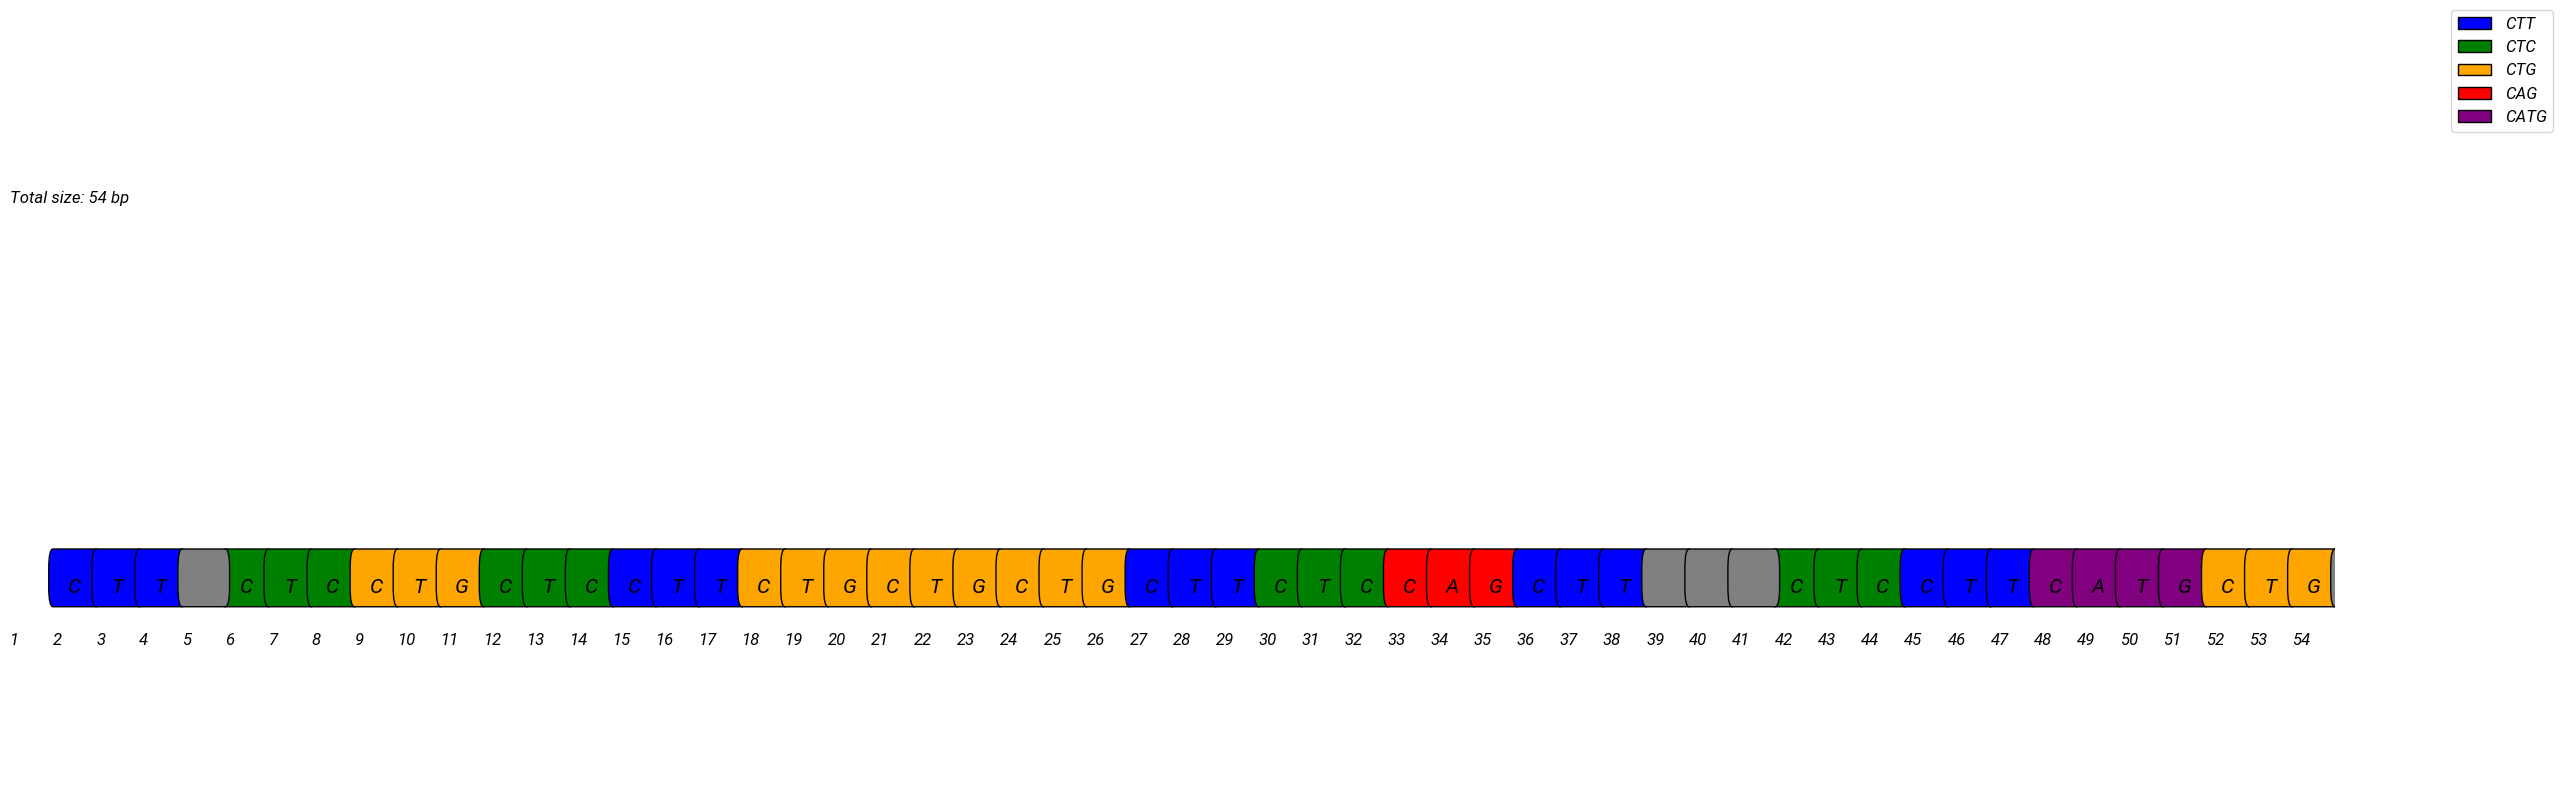

In [15]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib.font_manager import FontProperties

prop = FontProperties(fname='/usr/share/fonts/truetype/Roboto-Italic.ttf', size=12)
data = [
    (1, 3, 'CTT'),
    (5, 7, 'CTC'),
    (8, 10, 'CTG'),
    (11, 13, 'CTC'),
    (14, 16, 'CTT'),
    (17, 19, 'CTG'),
    (20, 22, 'CTG'),
    (23, 25, 'CTG'),
    (26, 28, 'CTT'),
    (29, 31, 'CTC'),
    (32, 34, 'CAG'),
    (35, 37, 'CTT'),
    (41, 43, 'CTC'),
    (44, 46, 'CTT'),
    (47, 50, 'CATG'),
    (51, 53, 'CTG'),
]
colors = {
    'CTT': 'blue',
    'CTC': 'green',
    'CTG': 'orange',
    'CAG': 'red',
    'CATG': 'purple'
}

fig, ax = plt.subplots(figsize=(30, 10))  # Increase height of the figure

# Adjust width and height scaling factors
width_scale = 1  # One box per base pair
height_scale = 0.1  # Height of each box

# Track covered positions
covered_positions = set()

# Create base pair positions with colors based on motifs
for (start, end, motif) in data:
    for position in range(start, end + 1):
        rect = FancyBboxPatch((position * width_scale, 0.5), width_scale, 0.5 * height_scale, 
                              boxstyle="round,pad=0.1", 
                              edgecolor='black', 
                              facecolor=colors[motif],
                              mutation_aspect=0.5)
        ax.add_patch(rect)
        covered_positions.add(position)
        ax.text(position * width_scale + 0.5, 0.50, motif[position - start], ha='center', va='center', color="black", fontsize=15, fontproperties=prop)

# Add gray boxes for base pairs not covered by any motifs
for i in range(1, 55):
    if i not in covered_positions:
        rect = FancyBboxPatch((i * width_scale, 0.5), width_scale, 0.5 * height_scale, 
                              boxstyle="round,pad=0.1", 
                              edgecolor='black', 
                              facecolor='gray',
                              mutation_aspect=0.5)
        ax.add_patch(rect)

# Set the limits of the plot
ax.set_xlim(0, 54 * width_scale)
ax.set_ylim(0, 2)

# Remove axes and ticks
ax.axis('off')

# Add an annotation on the plot that shows the total size of the region 
ax.annotate('Total size: 54 bp', xy=(0, 1.5), xytext=(0, 1.5), fontsize=12, fontproperties=prop)

# Add an annotation that shows the position of each base pair underneath the boxes
for i in range(0, 54):
    ax.annotate(str(i+1), xy=(i * width_scale, 0.45), xytext=(i * width_scale, 0.35), fontsize=12, fontproperties=prop)

# Add a more stylish legend
handles = [FancyBboxPatch((0, 0), 1, 1, boxstyle="round,pad=0.1", edgecolor='black', facecolor=colors[motif]) for motif in colors]
labels = list(colors.keys())
ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop=prop)

# Display the plot
plt.show()
#CTT,CTC,CTG,CAG,CATG;SVTYPE=VNTR;ALTANNO_H1=0,1,2,1,0,2,0,0,0,1,3,0,2,1,0,4,2 Vamos
# CATG,CTT,CTC,CTG,CAG    1,2,3,2,1,3,3,3,1,2,4,1,2,1,0,3 TandemTwister
#                         1,2,3,2,1,3,1,1,1,2,4,1,2,1,0,3
                        # 1,2,3,2,1,3,1,1,1,2,4,1,0,0,3
                        # 1,2,3,2,1,3,1,1,1,2,4,1,0,0,3